In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

ImportError: cannot import name 'Mapping' from 'collections' (c:\Program Files\Python310\lib\collections\__init__.py)

In [1266]:
df = pd.read_csv("C:\\Users\\User\\Downloads\\DemandForecasting\\demand_Data.csv",parse_dates=True)

In [1207]:
df.shape

(3942, 2)

In [1208]:
df.head()

,Date,Energy Required (MU)
0,02-May-12,255.639
1,03-May-12,258.470
2,04-May-12,261.393
3,05-May-12,252.866
4,06-May-12,250.566


In [1209]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3942 entries, 0 to 3941
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  3941 non-null   object 
 1   Energy Required (MU)  3940 non-null   float64
dtypes: float64(1), object(1)
memory usage: 61.7+ KB


In [1210]:
# Assuming your DataFrame is named df
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', format='%d-%b-%y')
df['Date'] = df['Date'].dt.strftime('%d-%m-%Y')

In [1211]:
df.head()

,Date,Energy Required (MU)
0,02-05-2012,255.639
1,03-05-2012,258.470
2,04-05-2012,261.393
3,05-05-2012,252.866
4,06-05-2012,250.566


In [1212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3942 entries, 0 to 3941
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  3939 non-null   object 
 1   Energy Required (MU)  3940 non-null   float64
dtypes: float64(1), object(1)
memory usage: 61.7+ KB


In [1213]:
df.tail(5)

,Date,Energy Required (MU)
3937,13-05-2023,224.030
3938,14-05-2023,226.349
3939,NaN,731865.506
3940,NaN,NaN
3941,NaN,NaN


In [1214]:
df.dropna(axis=0,inplace=True)

In [1215]:
df['Date']=pd.to_datetime(df['Date'])

C:\Users\User\AppData\Local\Temp\ipykernel_8268\3023999556.py:1: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.



In [1216]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3939 entries, 0 to 3938
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  3939 non-null   datetime64[ns]
 1   Energy Required (MU)  3939 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 92.3 KB


<Axes: xlabel='Date', ylabel='Energy Required (MU)'>

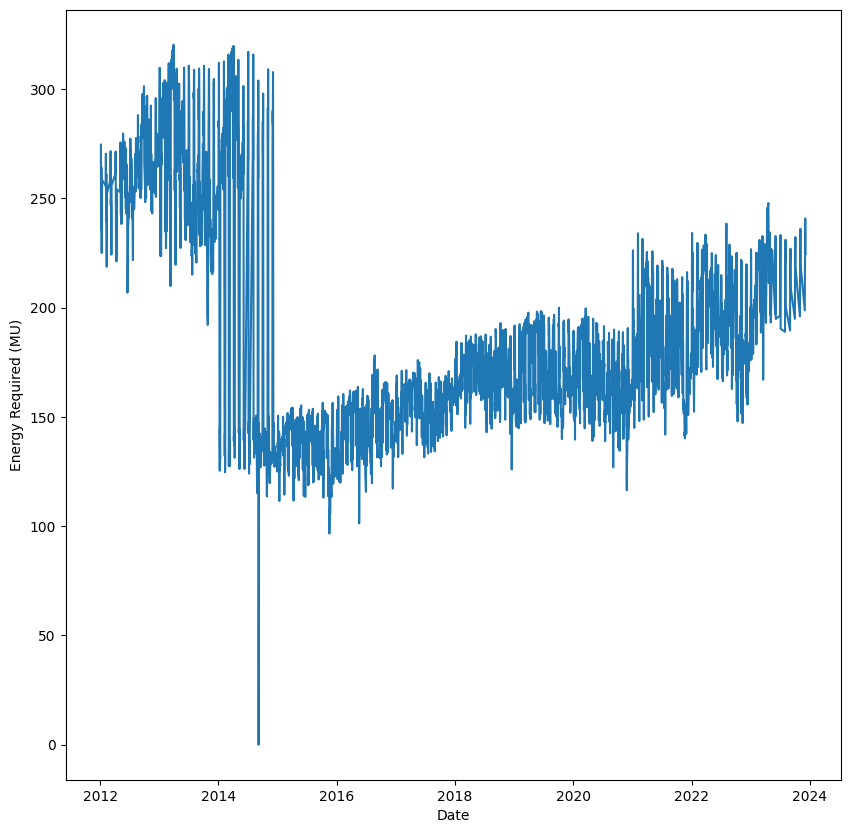

In [1217]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.lineplot(x=df['Date'],y=df['Energy Required (MU)'])

In [1218]:
df1=df["Energy Required (MU)"]

In [1219]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
df_scaled_train = sc.fit_transform(np.array(df["Energy Required (MU)"]).reshape(-1,1))
print(type(df_scaled_train))
df_scaled_train.shape

<class 'numpy.ndarray'>


(3939, 1)

In [1220]:
# split into train and test sets
train_size = int(len(df_scaled_train) * 0.80)
test_size = len(df_scaled_train) - train_size
train, test = df_scaled_train[0:train_size,:], df_scaled_train[train_size:len(df_scaled_train),:]

In [1221]:
train_size

3151

In [1222]:
test_size

788

In [1223]:
def split_sequence(sequence, n_steps,future_window):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i+n_steps+future_window
        if end_ix > (len(sequence)-future_window):
           break
        seq_x, seq_y = sequence[i:i+n_steps],sequence[i+n_steps:end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X),np.array(y)



In [1224]:
n_steps =30
future_window= 1

In [1225]:
trainX, trainY = split_sequence(train, n_steps,future_window)
testX, testY = split_sequence(test,  n_steps,future_window)

In [1226]:
trainY.shape
3151-3120

31

In [1227]:
testX.shape
788-757

31

Vanilla LSTM

In [1228]:
model = Sequential()
model.add(LSTM(50,activation='relu',input_shape=(n_steps,n_features)))
model.add(Dense(testY.shape[1]))
model.compile(optimizer='adam',loss='mse')

Stacked LSTM

In [1261]:
model_2 = Sequential()
model_2.add(LSTM(50,activation='relu',return_sequences = True,input_shape=(n_steps,n_features)))
model_2.add(LSTM(25,activation='relu'))
model_2.add(Dense(testY.shape[1]))
model_2.compile(optimizer='adam',loss='mse')

Bidirectional LSTM

In [1230]:
model_3 = Sequential()
model_3.add(Bidirectional(LSTM(50,activation='relu',input_shape=(n_steps,n_features))))
model_3.add(Dense(testY.shape[1]))
model_3.compile(optimizer='adam',loss='mse')

In [1231]:
n_features = 1
trainX = trainX.reshape((trainX.shape[0],trainX.shape[1],n_features))

In [1232]:
trainX.shape[0]

3120

In [1233]:
trainY = trainY.reshape((trainY.shape[0],trainY.shape[1],n_features))

In [1263]:
from keras.callbacks import EarlyStopping
history = model_2.fit(trainX,trainY,epochs=50,validation_data=(testX,testY),callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

Epoch 1/50
98/98 [==============================] - ETA: 0s - loss: 0.0509

ValueError: Data cardinality is ambiguous:
  x sizes: 788
  y sizes: 757
Make sure all arrays contain the same number of samples.

In [1258]:
from keras.callbacks import EarlyStopping
history = model.fit(trainX,trainY,epochs=50,callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

Epoch 1/50
98/98 [==============================] - 1s 11ms/step - loss: 5.3980e-04
Epoch 2/50
98/98 [==============================] - 1s 13ms/step - loss: 5.1106e-04
Epoch 3/50
98/98 [==============================] - 1s 8ms/step - loss: 5.2449e-04
Epoch 4/50
98/98 [==============================] - 1s 8ms/step - loss: 5.1847e-04
Epoch 5/50
98/98 [==============================] - 1s 11ms/step - loss: 5.3457e-04
Epoch 6/50
98/98 [==============================] - 1s 13ms/step - loss: 5.0446e-04
Epoch 7/50
98/98 [==============================] - 1s 13ms/step - loss: 5.3073e-04
Epoch 8/50
98/98 [==============================] - 1s 11ms/step - loss: 5.2252e-04
Epoch 9/50
98/98 [==============================] - 1s 12ms/step - loss: 5.3551e-04
Epoch 10/50
98/98 [==============================] - 1s 12ms/step - loss: 5.3549e-04
Epoch 11/50
98/98 [==============================] - 1s 11ms/step - loss: 5.3228e-04
Epoch 12/50
98/98 [==============================] - 1s 12ms/step - loss: 5.

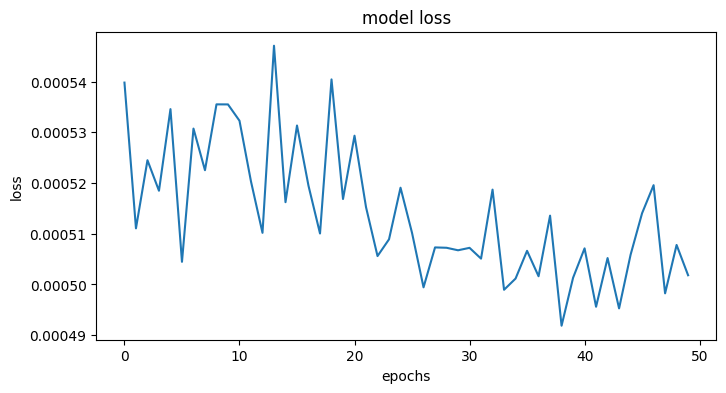

In [1260]:
#without using validation data
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
#plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
#plt.legend(loc='upper right')
plt.show()


In [1234]:
from keras.callbacks import EarlyStopping
history = model.fit(trainX,trainY,epochs=50,validation_data=(testX,testY),callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

Epoch 1/50
98/98 [==============================] - 4s 12ms/step - loss: 0.0557 - val_loss: 0.0015
Epoch 2/50
98/98 [==============================] - 1s 15ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 3/50
98/98 [==============================] - 1s 10ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 4/50
98/98 [==============================] - 1s 9ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 5/50
98/98 [==============================] - 1s 10ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 6/50
98/98 [==============================] - 1s 10ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 7/50
98/98 [==============================] - 1s 10ms/step - loss: 9.9593e-04 - val_loss: 0.0012
Epoch 8/50
98/98 [==============================] - 1s 9ms/step - loss: 8.9481e-04 - val_loss: 9.1675e-04
Epoch 9/50
98/98 [==============================] - 1s 10ms/step - loss: 8.7132e-04 - val_loss: 9.6007e-04
Epoch 10/50
98/98 [==============================] - 1s 11ms/step - loss: 8.6851e-04 - val_

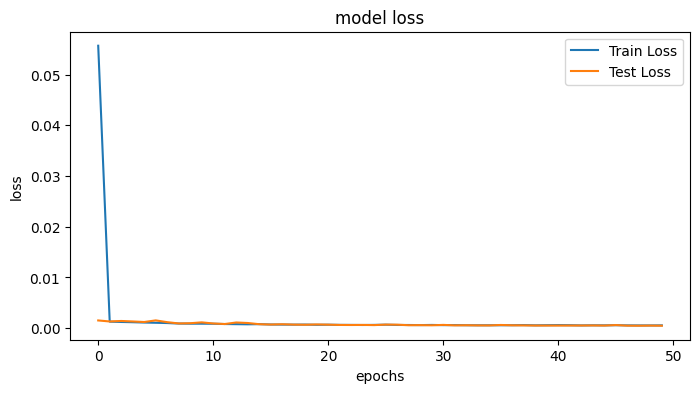

In [1235]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()


In [1236]:

# make predictions
trainPredict = model.predict(trainX)


98/98 [==============================] - 1s 5ms/step


In [1237]:
trainPredict_rescale = sc.inverse_transform(trainPredict)

In [1238]:
trainY_rescaled = sc.inverse_transform(trainY.reshape(3120,1))

In [1239]:
trainY_rescaled.shape

(3120, 1)

In [1240]:
testX.shape

(757, 30, 1)

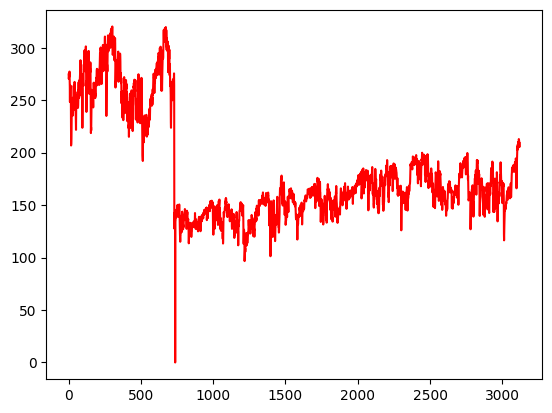

In [1241]:
plt.plot(df.iloc[0:3120,0].index.values,trainY_rescaled,color='red')

In [1242]:
test_arr_X,test_arrY = split_sequence(df_scaled_train[3120:3939],n_steps,future_window)

In [1243]:
test_arr_X.shape

(788, 30, 1)

In [1244]:
testX = test_arr_X.reshape((test_arr_X.shape[0],test_arr_X.shape[1],n_features))

In [1267]:
testY_rescaled = sc.inverse_transform(test_arrY.reshape(788,1))

In [1245]:
testX.shape

(788, 30, 1)

In [1246]:
testPredict = model.predict(testX)

25/25 [==============================] - 0s 5ms/step


In [1247]:
testPredict_rescale = sc.inverse_transform(testPredict)

In [1248]:
testPredict_rescale

array([[209.09099],
       [212.56642],
       [216.79672],
       [215.83875],
       [214.82094],
       [211.59416],
       [211.14122],
       [210.48955],
       [215.71622],
       [217.19034],
       [217.00137],
       [218.29472],
       [219.25818],
       [220.46198],
       [218.98543],
       [220.06306],
       [221.21461],
       [224.99252],
       [225.96382],
       [232.55664],
       [231.04736],
       [222.45264],
       [225.6962 ],
       [220.824  ],
       [222.25066],
       [219.86128],
       [219.21239],
       [215.19098],
       [215.60635],
       [217.56932],
       [213.11757],
       [207.80142],
       [184.4655 ],
       [197.85167],
       [204.67981],
       [207.50621],
       [210.54555],
       [208.919  ],
       [209.0575 ],
       [206.30173],
       [196.16603],
       [195.60492],
       [197.54724],
       [204.64441],
       [205.65479],
       [206.55945],
       [206.40544],
       [203.82303],
       [197.15645],
       [197.80829],


In [1249]:
trainY_rescaled

array([[274.57 ],
       [270.43 ],
       [271.587],
       ...,
       [206.803],
       [205.298],
       [209.271]])

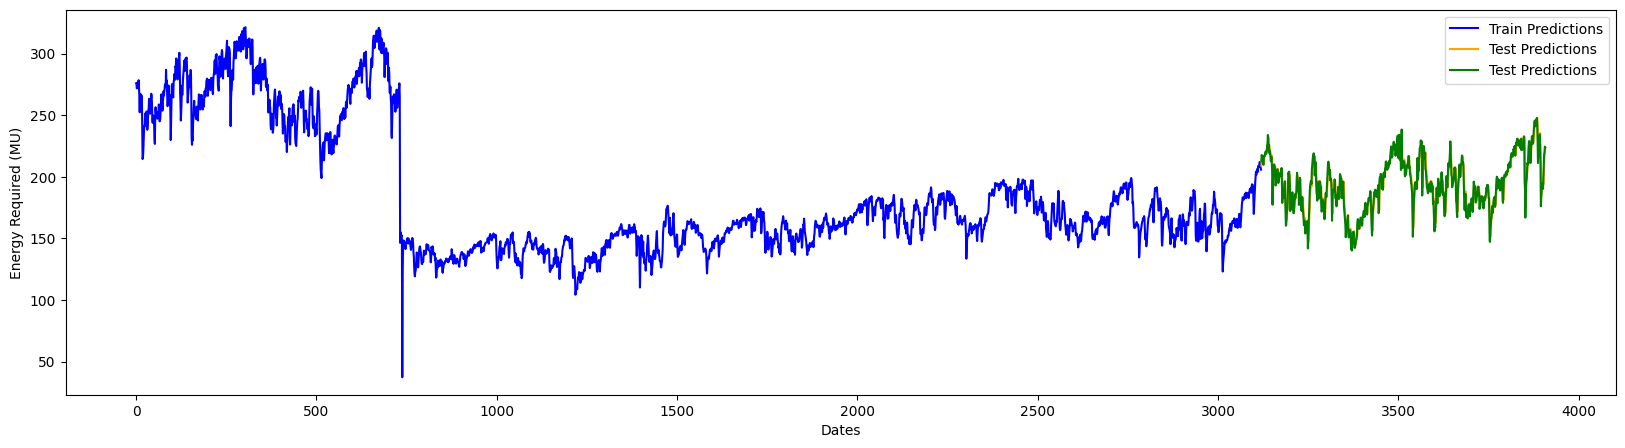

In [1269]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
plt.plot(df.iloc[0:3120, 0].index, trainPredict_rescale, color='blue', label='Train Predictions')
plt.plot(df.iloc[3120:3120+788, 0].index, testPredict_rescale, color='orange', label='Test Predictions')
plt.plot(df.iloc[3120:3120+788, 0].index,testY_rescaled, color='green', label='Test Predictions')
plt.xlabel('Dates')
plt.ylabel('Energy Required (MU)')
plt.legend()
plt.show()


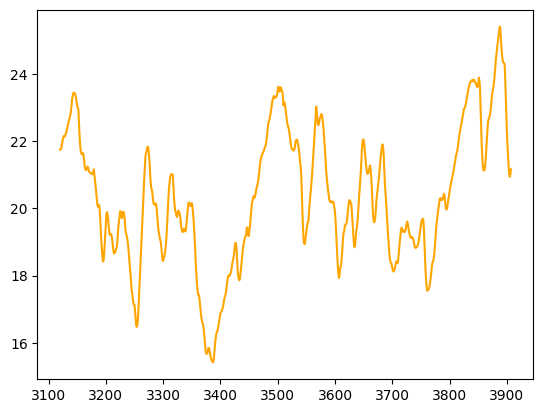

In [1035]:
plt.plot(df1.iloc[3120:3120+788].index,testPredict_rescale,color='orange')

In [668]:
test_pred = pd.DataFrame(testPredict_rescale.reshape(-1,1), columns=['predicted_demand'])


In [742]:
df1_new=df1.values
test_arr = df1_new[len(df1_new)-len(test)-30:]

In [746]:
test_arr_1 = sc.transform(test_arr.reshape(-1,1))
test_arr_1.shape

(818, 1)

In [747]:
n_hops = 30
n_features = 1
X_test = []
for i in range(n_hops, test_arr_1.shape[0]):
    X_test.append(test_arr_1[i-n_hops:i])

X_test = np.array(X_test)

In [748]:
y_pred = model.predict(X_test)

25/25 [==============================] - 0s 5ms/step


In [753]:
y_test_pred_actual=sc.inverse_transform(y_pred)

In [754]:
y_test_pred_actual[-1]

array([220.99974], dtype=float32)

1/1 [==============================] - 0s 32ms/step


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 1 and the array at index 1 has size 30

ValueError: x and y must have same first dimension, but have shapes (400,) and (30, 1)

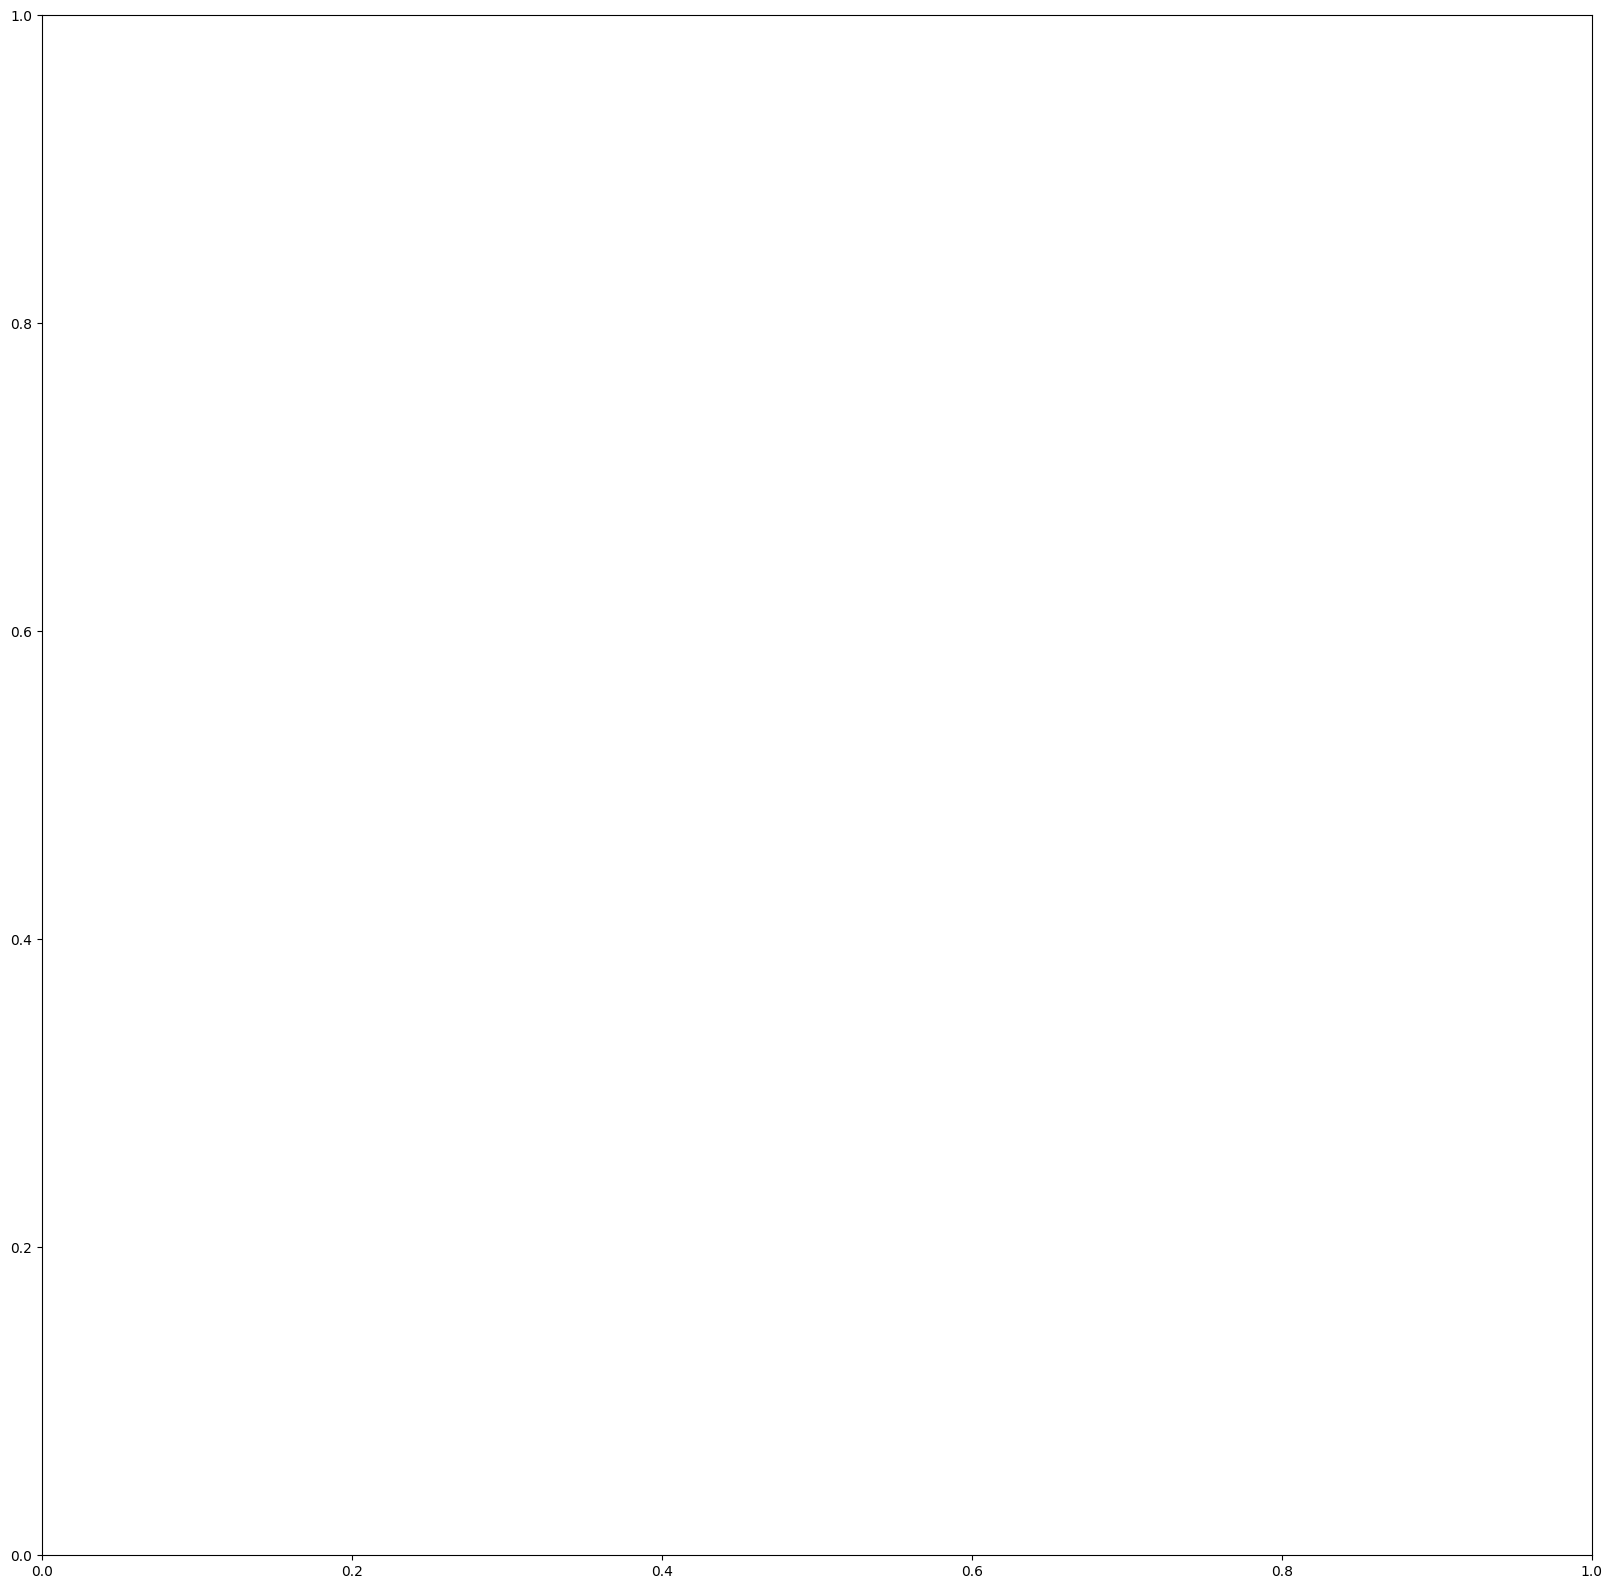

In [444]:
import seaborn as sns
aa=[x for x in range(200)]
plt.figure(figsize=(20,20))
plt.plot(aa, testY[0][:200], marker='.', label="actual")
plt.plot(aa, testPredict_rescale[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [277]:
model_2.fit(trainX,trainY,epochs=50,verbose=0)

In [130]:
model_3.fit(trainX,trainY,epochs=100,batch_size=10,verbose=0)

In [230]:
3939-3879

60

,Date,Energy Required (MU)
3151,16-03-2021,217.741
3152,17-03-2021,216.073
3153,18-03-2021,214.938
3154,19-03-2021,210.983
3155,20-03-2021,210.658
...,...,...
3934,10-05-2023,218.349
3935,11-05-2023,219.604
3936,12-05-2023,224.523
3937,13-05-2023,224.030


In [373]:
X_input = np.array(df['Energy Required (MU)'].iloc[3938:(3938+60)])

In [374]:
X_input = X_input.reshape((1,n_steps,n_features))

ValueError: cannot reshape array of size 1 into shape (1,60,1)

In [272]:
X_input.shape

(1, 60, 1)

In [273]:
yhat_1 = model.predict(X_input)

1/1 [==============================] - 0s 159ms/step


In [279]:
yhat_2 = model_2.predict(X_input)

1/1 [==============================] - 0s 27ms/step


In [235]:
yhat_3 = model_3.predict(X_input,verbose=0)

In [274]:
print(yhat_1)

[[227.3039  232.07047 230.67651 227.18657 231.59381 233.36673 227.68626
  230.16867 227.80482 225.5773  229.13084 228.5133  223.63231 226.25797
  228.76479 229.1895  230.5147  222.70955 226.3388  226.43835 230.6738
  228.15904 229.04416 228.94012 230.47426 225.09883 227.8353  226.85976
  227.67522 226.28427]]


In [280]:
print(yhat_2)

[[78.51126  29.503084 62.18546  49.106857 71.842476 51.611904 84.56398
  54.583866 42.994038 15.729784 57.291336 26.041746 44.805656 61.33407
  48.826424 47.102993 48.951958 81.098526 48.12206  30.731749 85.97555
  61.06274  35.6172   58.939114 67.258354 32.469326 75.5712   29.372154
  51.48384  52.355114]]


In [281]:
print(yhat_3)

[[5741854.]]


GluonTS

In [143]:
!pip install "gluonts[torch]"

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
     -------- ------------------------------- 0.3/1.5 MB 9.6 MB/s eta 0:00:01
     ---------------- ----------------------- 0.6/1.5 MB 5.4 MB/s eta 0:00:01
     -------------------- ------------------- 0.8/1.5 MB 4.8 MB/s eta 0:00:01
     -------------------------- ------------- 1.0/1.5 MB 4.8 MB/s eta 0:00:01
     --------------------------------- ------ 1.2/1.5 MB 4.9 MB/s eta 0:00:01
     ---------------------------------------  1.5/1.5 MB 4.9 MB/s eta 0:00:01
     ---------------------------------------  1.5/1.5 MB 4.9 MB/s eta 0:00:01
     ---------------------------------------  1.5/1.5 MB 4.9 MB/s eta 0:00:01
     ---------------------------------------  1.5/1.5 MB 4.9 MB/s eta 0:00:01
     ---------------------------------------  1.5/1.5 MB 4.9 MB/s eta 0:00:01
     ---------------------------------------- 1.5/1.5 MB 3.0 MB/s eta 0


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [144]:
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\gluonts\json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [149]:
df.tail()

,Date,Energy Required (MU)
3934,2023-10-05,218.349
3935,2023-11-05,219.604
3936,2023-12-05,224.523
3937,2023-05-13,224.030
3938,2023-05-14,226.349


In [150]:
df["Date"]=pd.to_datetime(df['Date'],errors='coerce')

In [169]:
df = df.set_index("Date")

In [175]:
target_col = "Energy Required (MU)"
data = [{"start": df.index[0], "target": df[target_col].values}]

In [177]:
dataset = ListDataset(data, freq="M")

In [180]:
!pip install gluonts pytorch


Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for pytorch
Failed to build pytorch
  Running setup.py install for pytorch: started
  Running setup.py install for pytorch: finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\User\AppData\Local\Temp\pip-install-dhukokzr\pytorch_2902c9fd4bac43d18ab1ad8ca956a53a\setup.py", line 15, in <module>
          raise Exception(message)
      Exception: You tried to install "pytorch". The package named for PyTorch is "torch"
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  error: subprocess-exited-with-error
  
  × Running setup.py install for pytorch did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <

In [182]:
!pip install torch pytorch-forecasting pandas


Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/140.4 kB ? eta -:--:--
     ------------------------------------- -- 133.1/140.4 kB ? eta -:--:--
     -------------------------------------- 140.4/140.4 kB 2.1 MB/s eta 0:00:00
     ---------------------------------------- 0.0/390.6 kB ? eta -:--:--
     --------------------- ---------------- 225.3/390.6 kB 4.6 MB/s eta 0:00:01
     -------------------------------------  389.1/390.6 kB 6.0 MB/s eta 0:00:01
     -------------------------------------- 390.6/390.6 kB 4.0 MB/s eta 0:00:00
     ---------------------------------------- 0.0/134.1 kB ? eta -:--:--
     -------------------------------------  133.1/134.1 kB 7.7 MB/s eta 0:00:01
     -------------------------------------- 134.1/134.1 kB 2.0 MB/s eta 0:00:00
     ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
     ---- ----------------------------------- 0.2/1.8 MB 4.6 MB/s eta 0:00:01

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\User\\AppData\\Roaming\\Python\\Python310\\site-packages\\~orch\\lib\\asmjit.dll'
Check the permissions.


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


ModuleNotFoundError: No module named 'pytorch_forecasting'

ModuleNotFoundError: No module named 'gluonts.model.deepar'

ModuleNotFoundError: No module named 'gluonts.trainer'

In [178]:
prediction_length = 12  # Number of time steps to predict into the future
context_length = 36  # Number of time steps to use as input for prediction
num_layers = 2  # Number of layers in the network
num_cells = 40  # Number of cells in each layer
trainer = Trainer(epochs=10)  # Trainer for model training


NameError: name 'Trainer' is not defined

In [176]:
data

[{'start': '02-05-2012',
  'target': array([255.639, 258.47 , 261.393, ..., 224.523, 224.03 , 226.349])}]

Index(['Energy Required (MU)'], dtype='object')

In [185]:
dataset = PandasDataset(df, target='Energy Required (MU)')
training_data, test_gen = split(dataset, offset=-36)
test_data = test_gen.generate_instances(prediction_length=12, window=3)


model_new = DeepAREstimator(prediction_length = 12, freq ="M",trainer_kwargs={"max_epochs":5}).train(training_data)
forecasts = list(model.predict(test_data.input))

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\gluonts\dataset\pandas.py:331: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  freq = pd.infer_freq(index)


TypeError: object of type 'NoneType' has no len()